In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [5]:
# read in fangraphs-ripped stats. specifications:
#    fangraphs-denoted starter


def read_individual_standard_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","W","L","ERA","G","GS","CG","ShO",\
                                   "SV","HLD","BS","IP","TBF","H","R","ER","HR","BB",\
                                   "IBB","HBP","WP","BK","SO","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'i2','i2','i2','f4','i2','i2','i2','i2','i2','f4',\
                                    'f4','f4','f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')

def read_individual_battedball_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","BABIP","GB/FB","LD","GB","FB","IFFB","HRFB",\
                                   "RS","RS9","BLLS","STRKS","PIT","PULL","CENT","OPPO",\
                                   "SOFT","MED","HARD","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')


StartersPlayers2016 = read_individual_standard_stats('StartersPlayers2016.csv')
StartersBatted2016  = read_individual_battedball_stats('StartersBatted2016.csv')

StartersPlayers2015 = read_individual_standard_stats('StartersPlayers2015.csv')


#FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant


In [6]:

#
# calculate some extra stats
#

SP2016FIP  = (13.*StartersPlayers2016['HR'] +\
              (3.*(StartersPlayers2016['BB'] + StartersPlayers2016['HBP'])) -\
              2.*StartersPlayers2016['SO'])\
                /StartersPlayers2016['IP'] + 3.1437 # 3.143 is the 2016 correction
    
SP2016WHIP = (StartersPlayers2016['BB'] + StartersPlayers2016['H'])/StartersPlayers2016['IP']
SP2016HIP = (StartersPlayers2016['H'])/StartersPlayers2016['IP']




In [25]:


#
# match the player stats across datasets
#
PlayerDict = {}
PlayerDict['Player'] = StartersPlayers2016['Name']
PlayerDict['WHIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['BABIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['FIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['HIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['ERA'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['S-T'] = np.zeros(len(StartersPlayers2016['Name']))

#
# also add a 100 IP threshold
#
for x in range(0,len(PlayerDict['Player'])):
    if StartersPlayers2016['IP'][x] > 100.:
        PlayerDict['WHIP'][x] = SP2016WHIP[x]
        PlayerDict['FIP'][x] = SP2016FIP[x]
        PlayerDict['HIP'][x] = SP2016HIP[x]
        PlayerDict['ERA'][x] = StartersPlayers2016['ERA'][x]
 
        try:
            xx = np.where(StartersPlayers2016['Name'][x] == StartersBatted2016['Name'])[0]
            PlayerDict['BABIP'][x] = \
              StartersBatted2016['BABIP'][xx]
            PlayerDict['S-T'][x] = StartersBatted2016['STRKS'][xx]/StartersBatted2016['PIT'][xx]
        except:
            PlayerDict['BABIP'][x] = np.nan
            PlayerDict['S-T'][x] = np.nan
    else:
        PlayerDict['WHIP'][x] = np.nan
        PlayerDict['FIP'][x] = np.nan
        PlayerDict['HIP'][x] = np.nan
        PlayerDict['BABIP'][x] = np.nan

/Users/mpetersen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


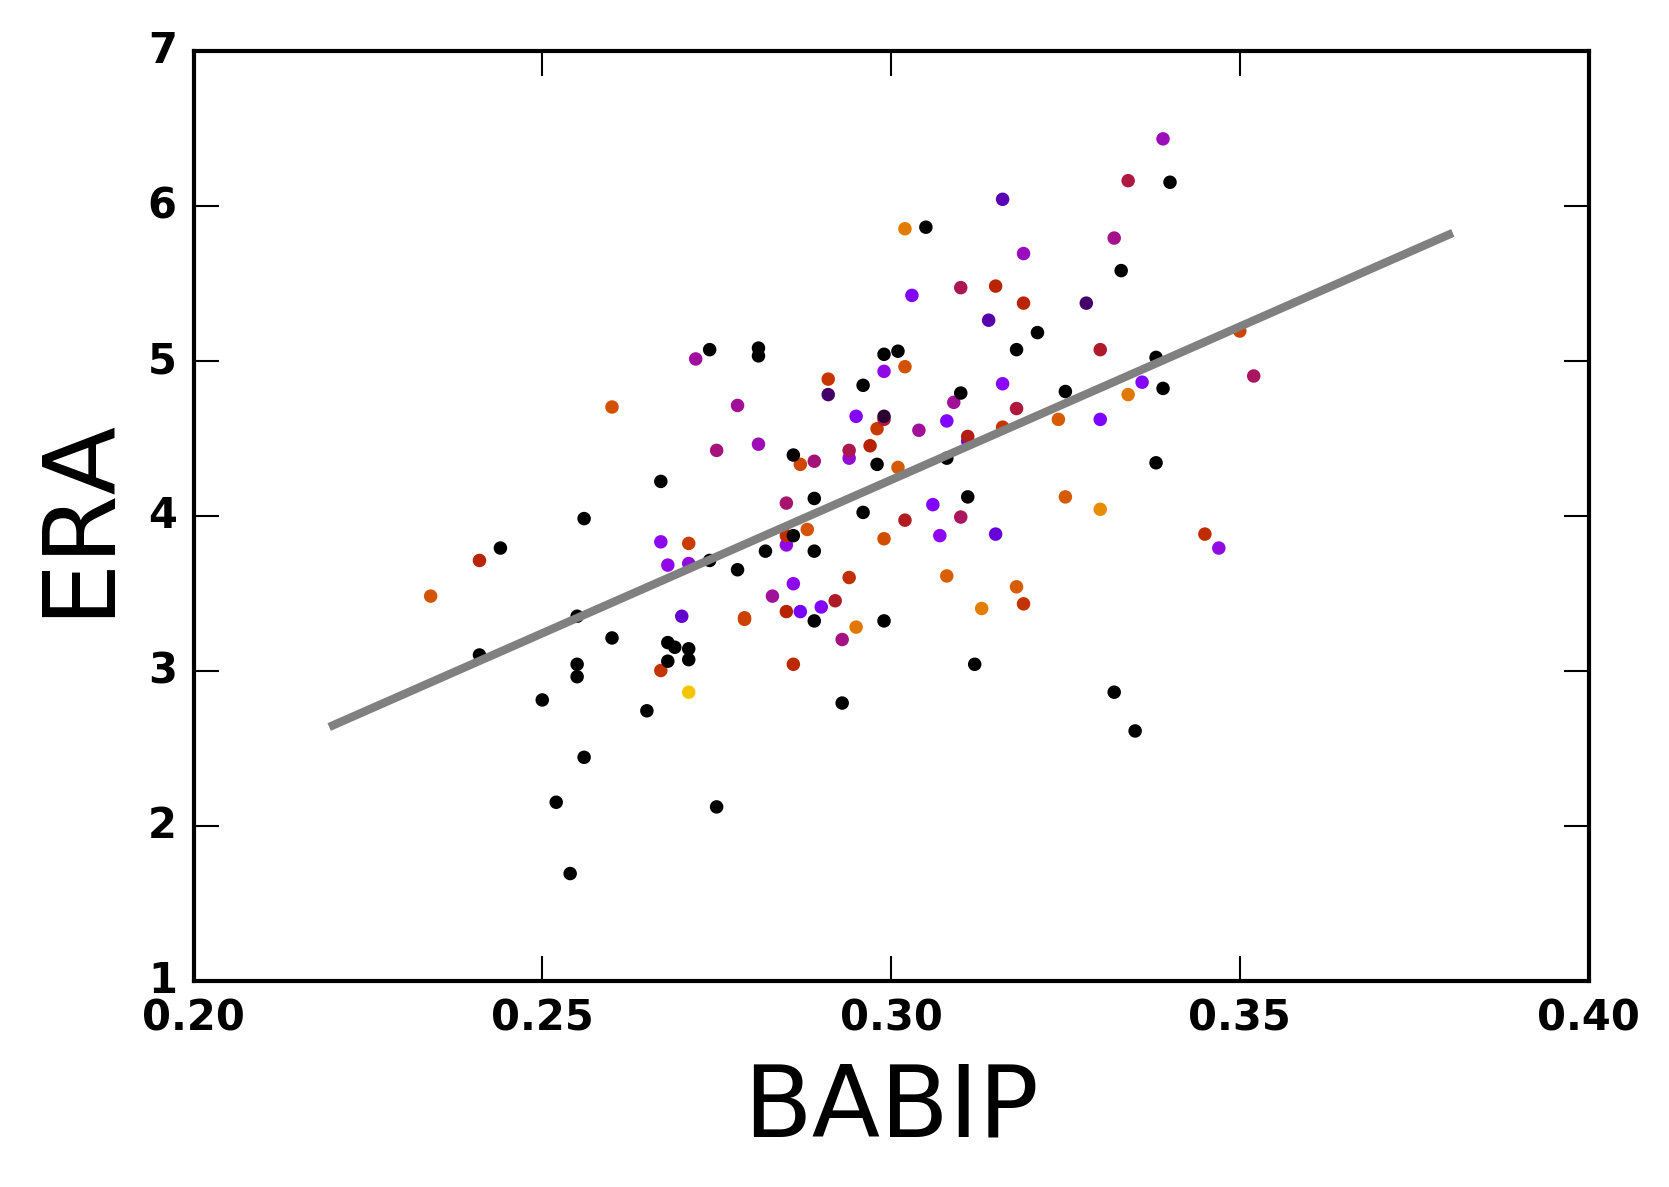

In [29]:

cvals = (PlayerDict['S-T'] - 0.6)/0.1

plt.scatter(PlayerDict['BABIP'],PlayerDict['ERA'],color=cm.gnuplot(cvals,1.),s=5.)

goodw = np.where(PlayerDict['BABIP'] > 0.)[0]
c = np.polyfit(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)

plt.plot(np.linspace(.22,.38,100),d(np.linspace(.22,.38,100)),color='gray')

#plt.axis([0.22,0.38,1.8,0.6])
plt.ylabel('ERA',size=24)
plt.xlabel('BABIP',size=24)




The next step is to set up the regression to see what we might expect from players going forward.

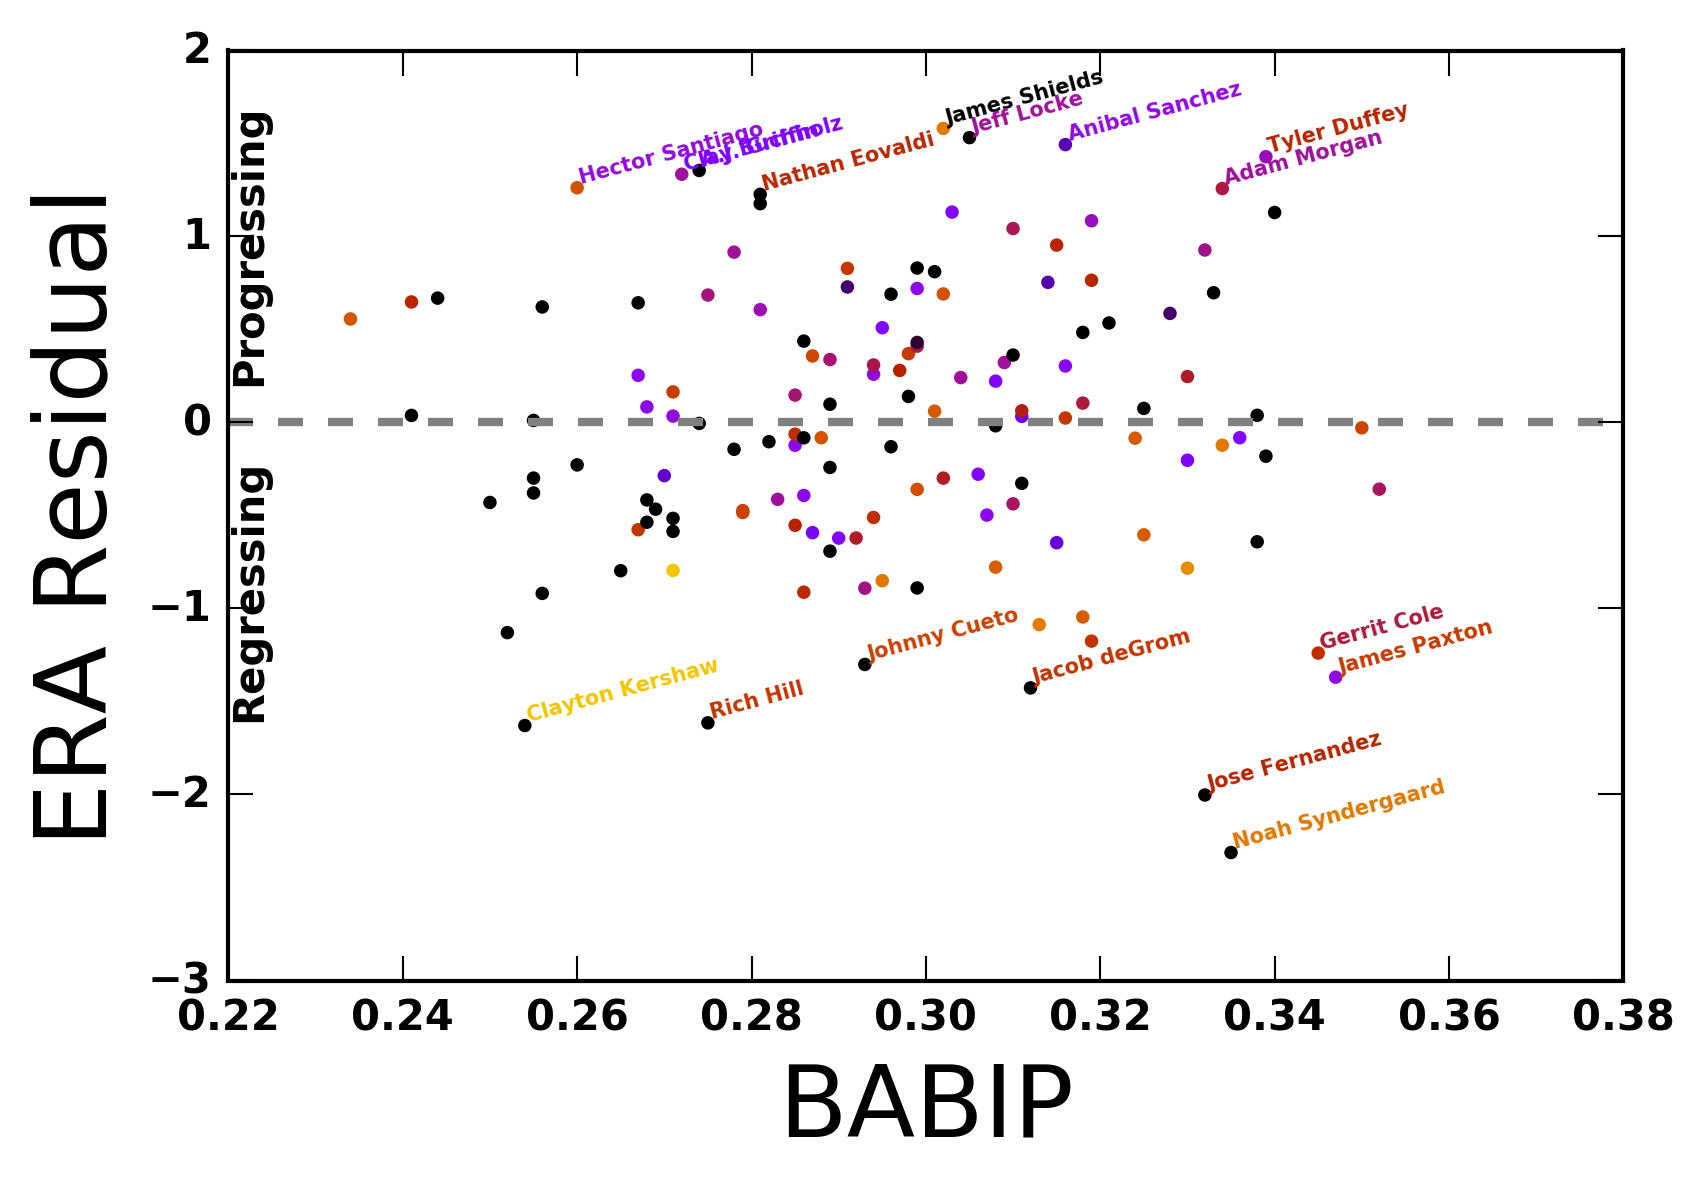

In [35]:

model = PlayerDict['ERA'] - d(PlayerDict['BABIP'])
cbar = plt.scatter(PlayerDict['BABIP'],model,color=cm.gnuplot(cvals,1.),s=5.)

plt.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

plt.axis([0.22,0.38,-3.,2.])
plt.xlabel('BABIP',size=24)
plt.ylabel('ERA Residual',size=24)
plt.text(0.22,-0.2,'Regressing',rotation=90,va='top')
plt.text(0.22,0.2,'Progressing',rotation=90,va='bottom')

for indx in range(0,len(PlayerDict['BABIP'])):
    if (PlayerDict['BABIP'][indx] > 0.0) & (model[indx] > 1.2):
        plt.text(PlayerDict['BABIP'][indx],model[indx],PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['S-T'][indx]-0.6)/0.1,1.))
    if (PlayerDict['BABIP'][indx] > 0.0) & (model[indx] < -1.2):
        plt.text(PlayerDict['BABIP'][indx],model[indx],PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['S-T'][indx] -0.6)/0.1,1.))





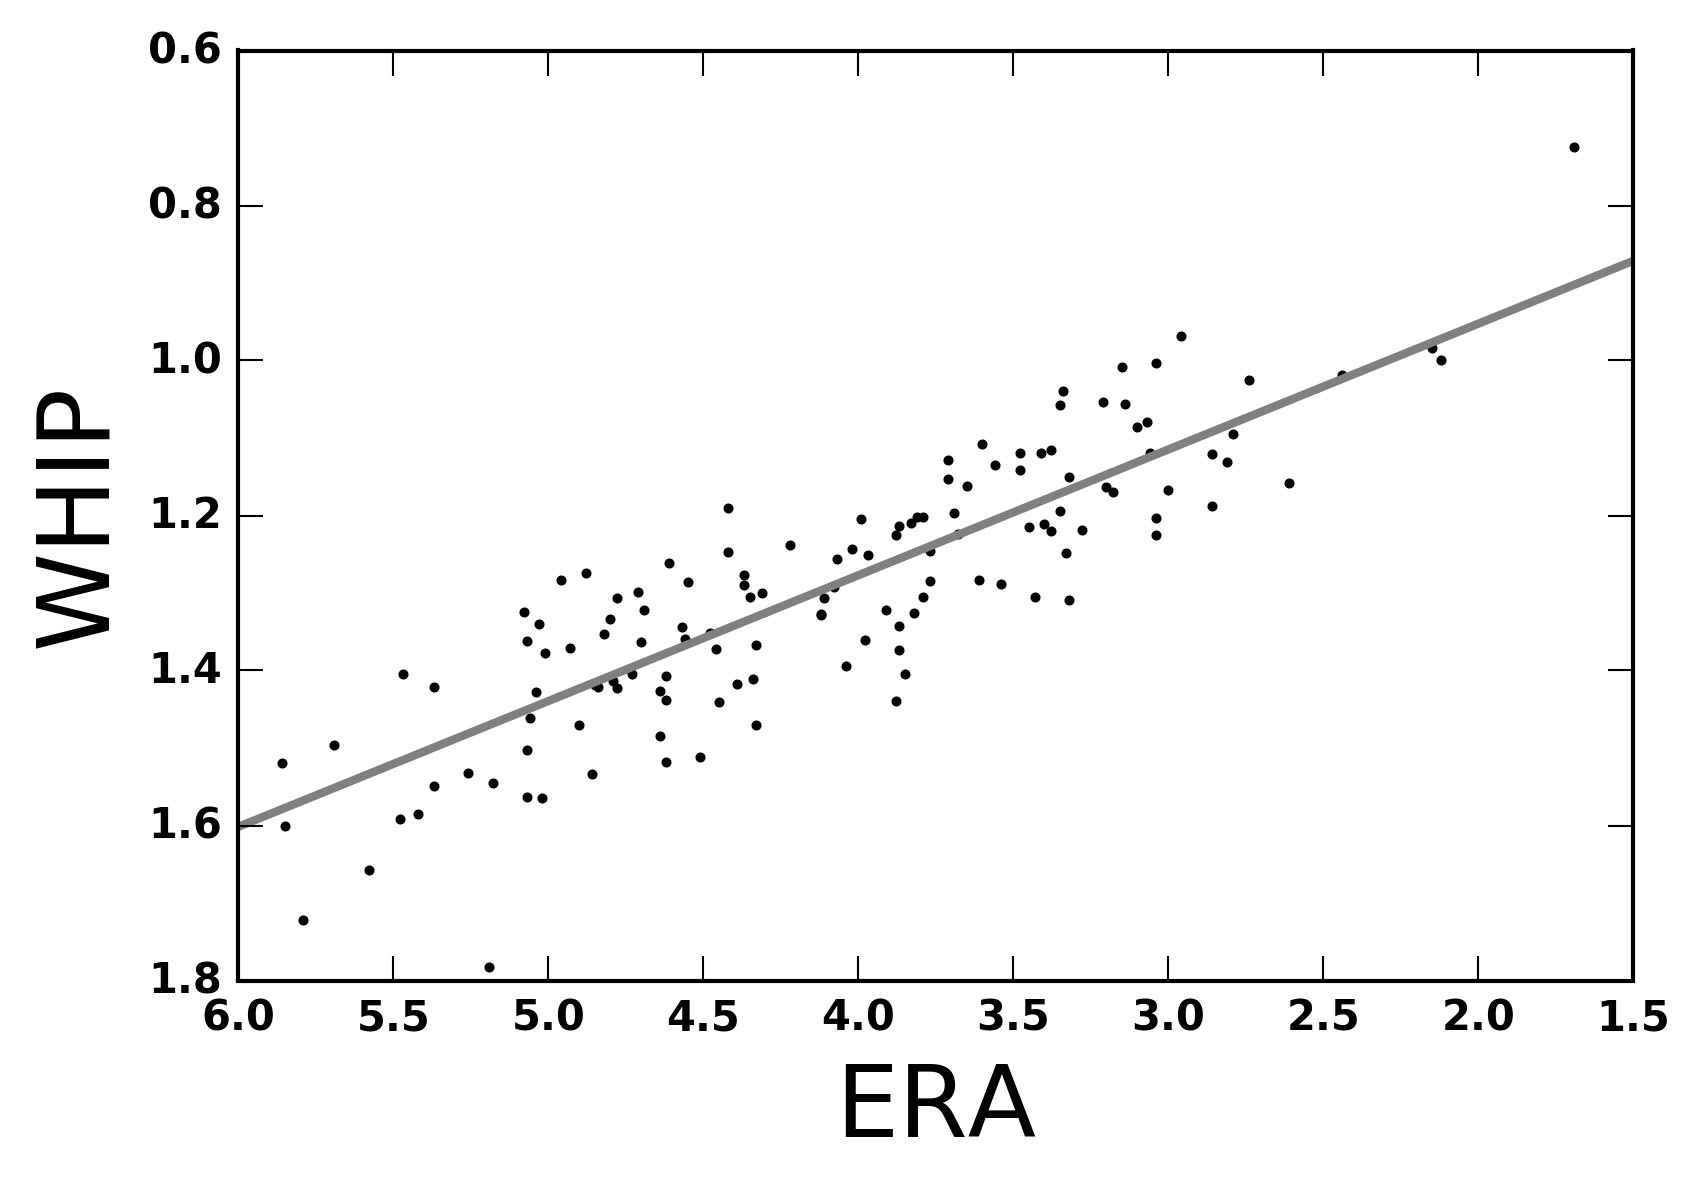

In [37]:
plt.scatter(PlayerDict['ERA'],PlayerDict['WHIP'],color='black',s=2.)

goodw = np.where(PlayerDict['ERA'] > 0.)[0]
c = np.polyfit(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],1)
d = np.poly1d(c)

plt.plot(np.linspace(0.0,6.0,100),d(np.linspace(0.0,6.0,100)),color='gray')

plt.axis([6.,1.5,1.8,0.6])
plt.ylabel('WHIP',size=24)
plt.xlabel('ERA',size=24)




/Users/mpetersen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


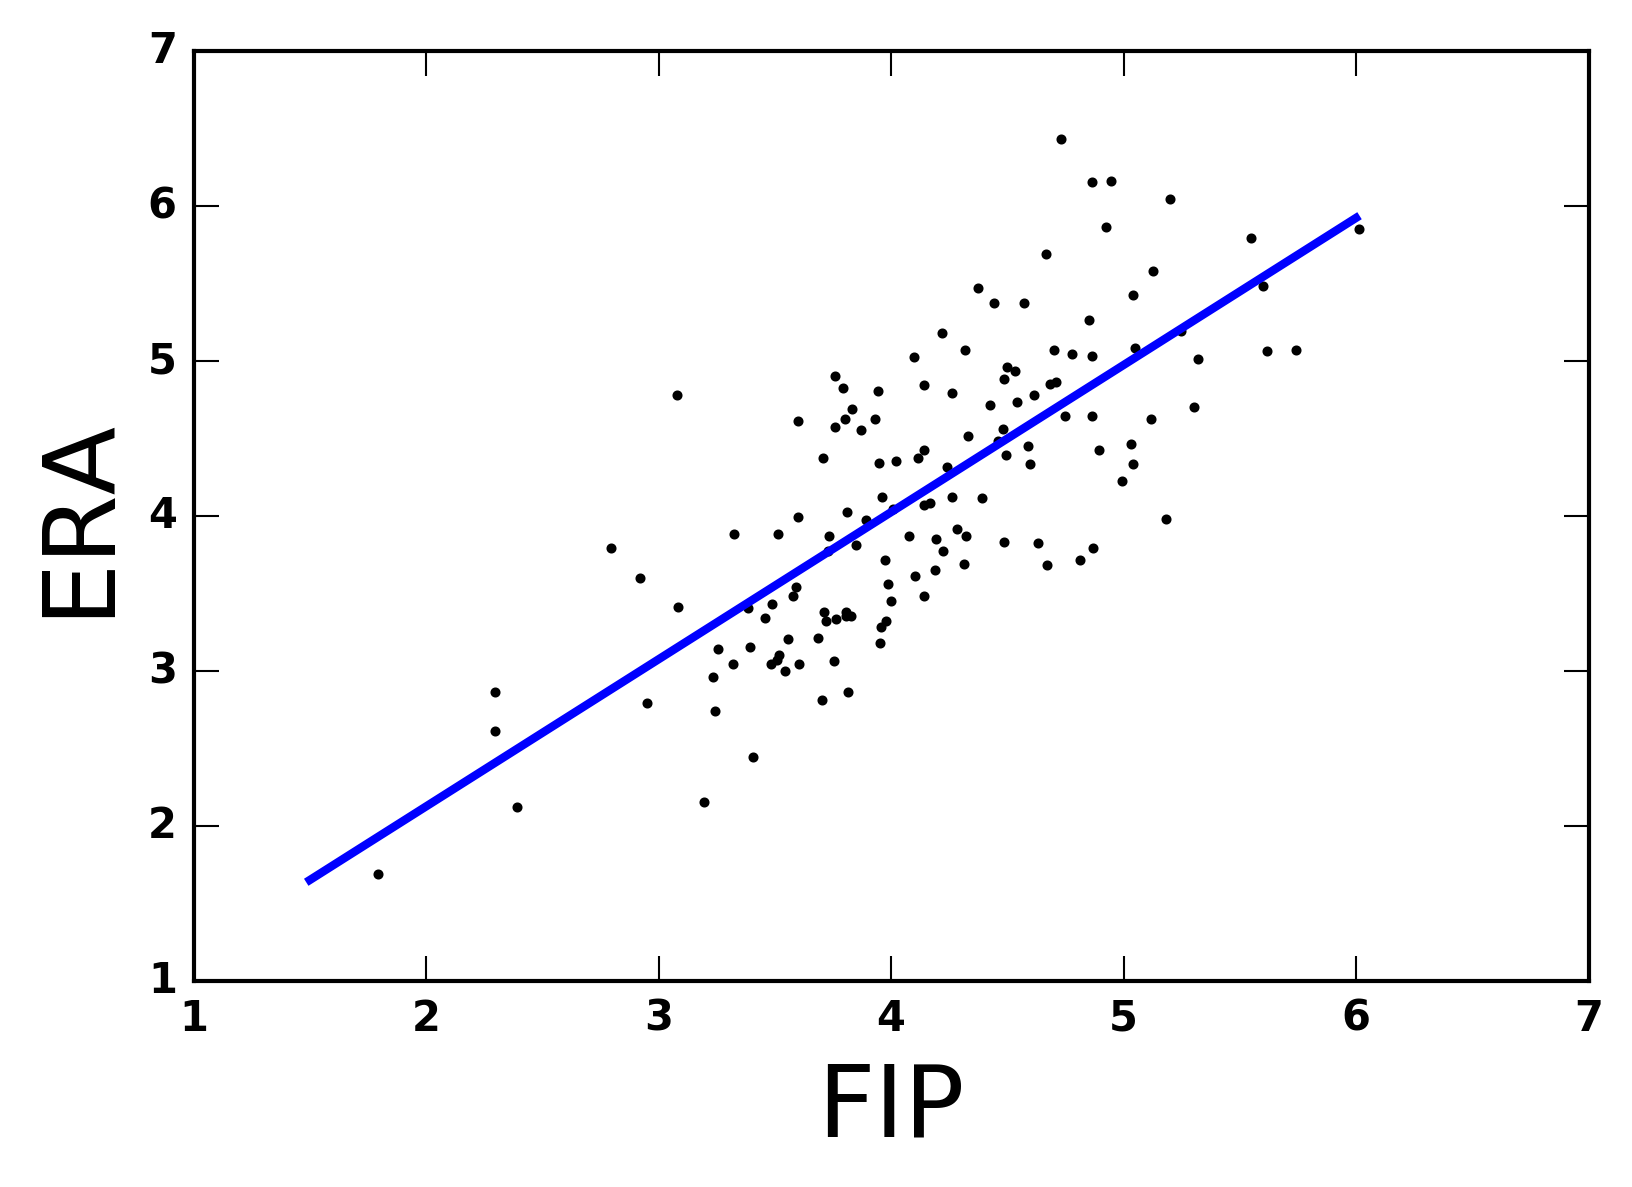

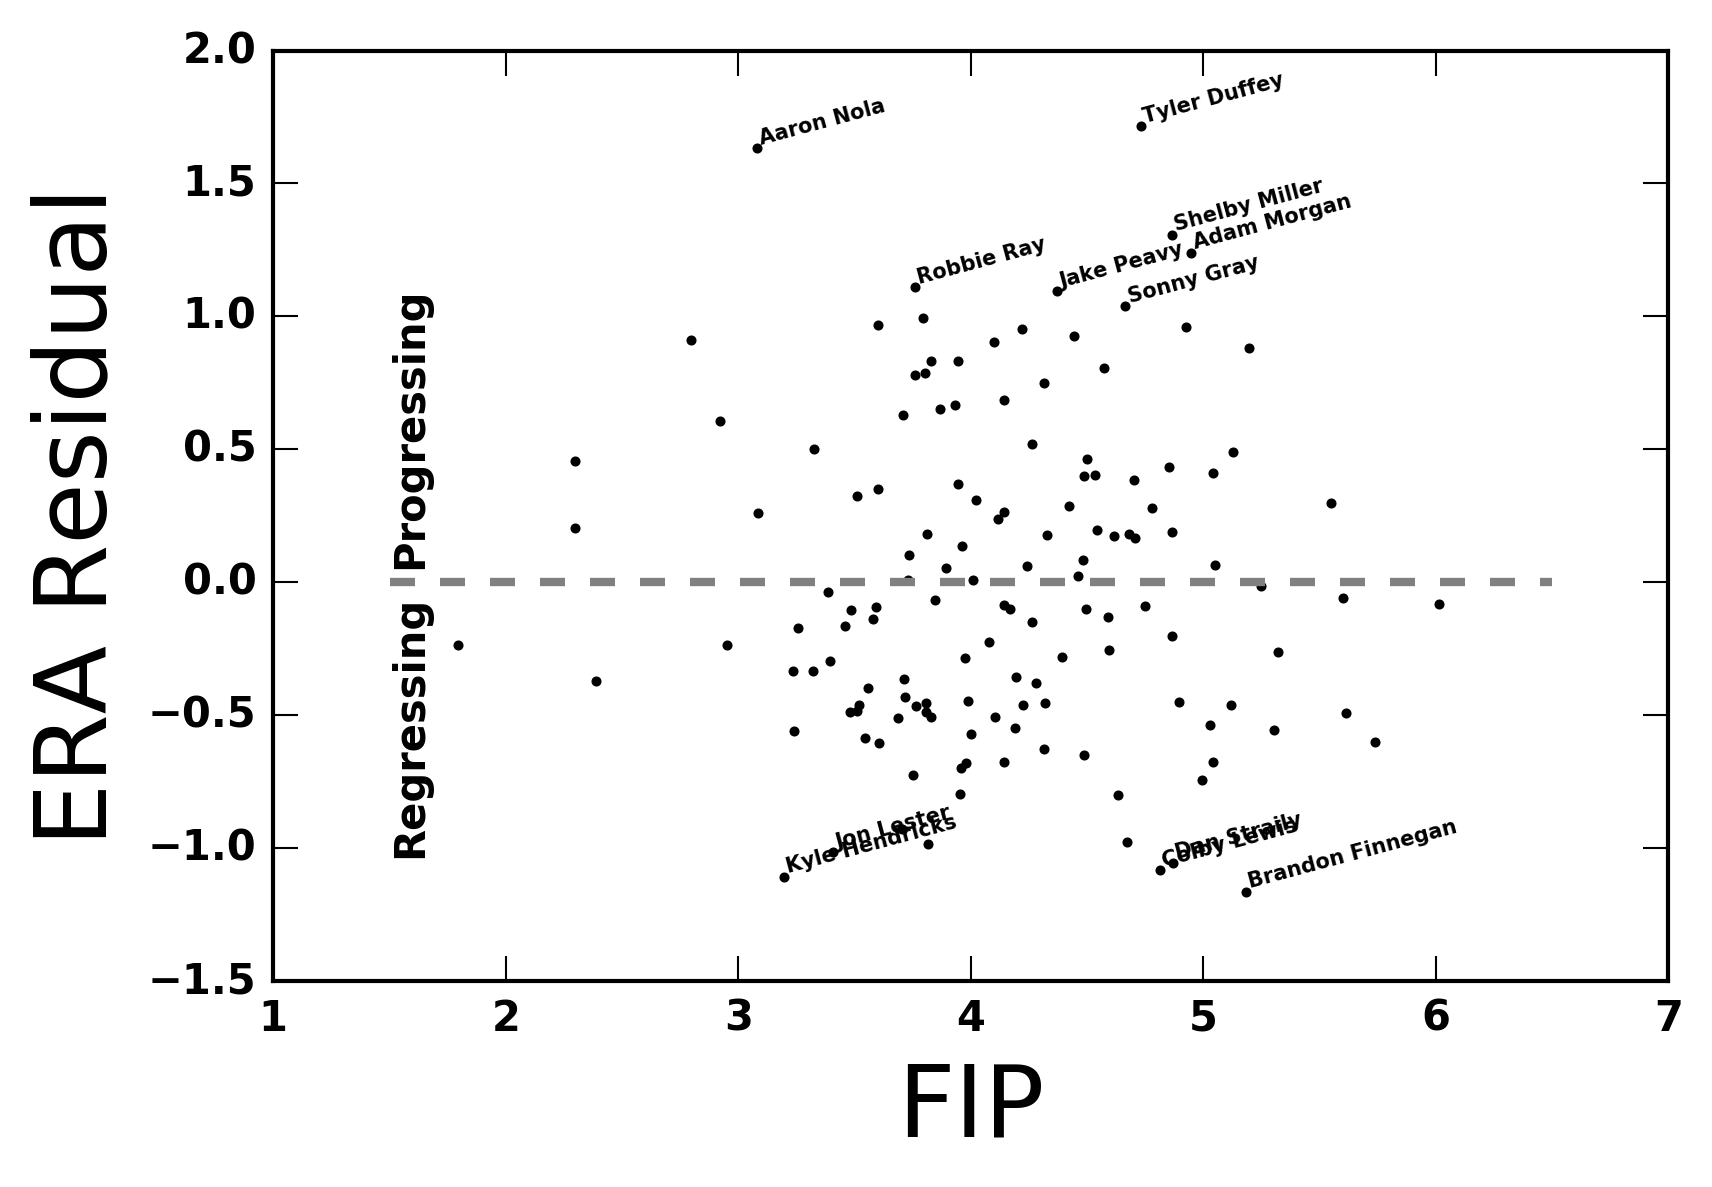

In [43]:

plt.figure()

plt.scatter(PlayerDict['FIP'],PlayerDict['ERA'],color='black',s=2.)

goodw = np.where(PlayerDict['FIP'] > 0.)[0]
c = np.polyfit(PlayerDict['FIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)

plt.plot(np.linspace(1.5,6.,100),d(np.linspace(1.5,6.,100)))

#plt.axis([1.5,6.5,0.5,2.3])
plt.xlabel('FIP',size=24)
plt.ylabel('ERA',size=24)

# model figure
plt.figure()

model = PlayerDict['ERA'] - d(PlayerDict['FIP'])
plt.scatter(PlayerDict['FIP'],model,color='black',s=2.)

plt.plot([1.5,6.5],[0.,0.],color='gray',linestyle='dashed')

#plt.axis([1.5,6.5,-0.4,0.4])
plt.xlabel('FIP',size=24)
plt.ylabel('ERA Residual',size=24)
plt.text(1.5,-0.05,'Regressing',rotation=90,va='top')
plt.text(1.5,0.05,'Progressing',rotation=90,va='bottom')

for indx in range(0,len(PlayerDict['BABIP'])):
    if (PlayerDict['FIP'][indx] > 0.0) & (PlayerDict['FIP'][indx] < 10.0) & (model[indx] > 1.0) & (model[indx] < 4.0):
        plt.text(PlayerDict['FIP'][indx],model[indx],PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom')
    if (PlayerDict['FIP'][indx] > 0.0) & (PlayerDict['FIP'][indx] < 10.0)& (model[indx] < -1.0) & (model[indx] > -4.):
        plt.text(PlayerDict['FIP'][indx],model[indx],PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom')



